In [54]:
from plotnine import *
import pandas
from solarized import *
import tikzplotlib
pandas.options.display.max_rows=10

In [55]:
# 1.{5end_to_end} tpch 1,2,3,4,5 with scale 1, 10
# 2 {5module4} and 3. module4 | also {5module4mem} and {5module4net}
# 3.{5tpchmodin} tpch 1, 4, 5 with modin on scale 10
# 4.{5micro_scales} micros with scale 1, 10 | also {5micro_traffic}
# 5.{5micro_net} micro join, selection with net=wan and scale 1

In [56]:
factors= ['wflow', 'optimizer', 'net', 'scale']
df=pandas.read_feather('specific-reports/5module4.feather')
df.columns

Index(['bytes_memory', 'cpu_percent', 'bytes_sent', 'bytes_recv',
       'snapshot_idx', 'proc_time', 'exitcode', 'db_time', 'shared_wall_time',
       'wflow', 'optimizer', 'scale', 'net'],
      dtype='object')

In [61]:
df['shared_wall_time'].value_counts()

0.0    3863
Name: shared_wall_time, dtype: int64

# CHECK

In [35]:
df['exitcode'].value_counts()

0    3863
Name: exitcode, dtype: int64

In [36]:
df.query("exitcode == 1")['wflow'].unique()

array([], dtype=object)

# PREPROCESS

In [37]:
overview = df.groupby(by=factors).first().reset_index()
overview.columns

Index(['wflow', 'optimizer', 'net', 'scale', 'bytes_memory', 'cpu_percent',
       'bytes_sent', 'bytes_recv', 'snapshot_idx', 'proc_time', 'exitcode',
       'db_time', 'shared_wall_time'],
      dtype='object')

In [38]:
overview.rename(columns={"db_time":"transfer_time"}, inplace=True)
overview["py_time"] = overview["shared_wall_time"] - overview["transfer_time"]

In [39]:
module4 = overview[["wflow", "optimizer", "py_time", "transfer_time"]]

In [52]:
module4

,wflow,optimizer,py_time,transfer_time
0,module4.py,base,0.0,0.0
1,module4.py,optimized,0.0,0.0


# {5module4}

In [40]:
plot_df = module4.melt(id_vars=["wflow", "optimizer"], value_vars=["py_time", "transfer_time"],
                    value_name='measurement', var_name='var')


In [41]:
plot = (
        ggplot(plot_df, aes('optimizer', y='measurement', fill='var'))
        + geom_col(width=0.3)
        #+ scale_fill_manual(values=cdict) 
        + facet_wrap('wflow', scales='free')
        + xlab("Optimization Method")
        + ylab("Time (in sec.)")
        + theme(figure_size=(5, 2.5),
               subplots_adjust={'hspace': 1, 'wspace': 0.25})
    )

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 5 x 2.5 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5end_to_end.png
E:\ssdapps\anaconda\lib\site-packages\tikzplotlib\_save.py:390: UserWarning: tikzplotlib: Don't know how to handle object <class 'matplotlib.offsetbox.AnchoredOffsetbox'>.


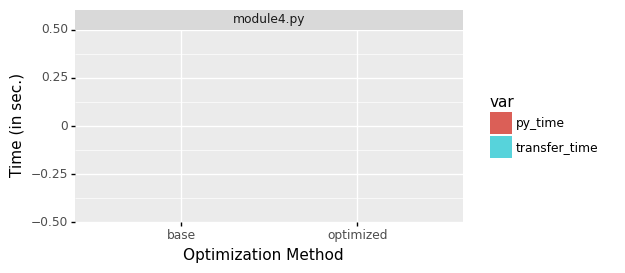

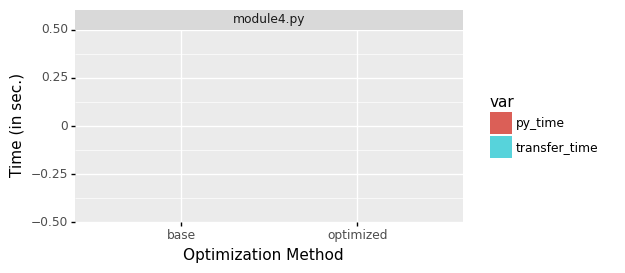

<ggplot: (107509058588)>

In [42]:
plot.save("specific-plots/5end_to_end.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5end_to_end.tikz', figure=matplot)
display(plot)


# {5module4net}

In [43]:
overview['gb_net'] = overview['bytes_recv']/10**9

In [44]:
plot_df = overview[["wflow", "optimizer", "gb_net"]]

In [45]:
plot = (
    ggplot(plot_df, aes('optimizer', y='gb_net'))
    + geom_col(width=0.3)
    #+ scale_fill_manual(values=cdict)
    + xlab("Optimization Method")
    + ylab("Time (in sec.)")
    + facet_wrap('wflow', scales='free')
    + theme(figure_size=(5, 2.5),
           subplots_adjust={'hspace': 1, 'wspace': 0.25})
)

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 5 x 2.5 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5end_to_end.png


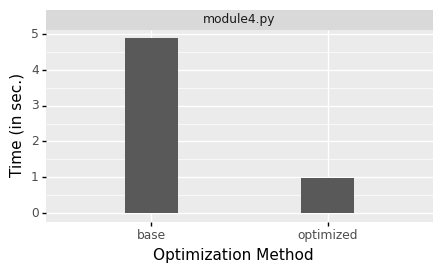

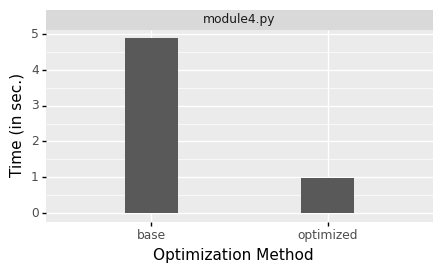

<ggplot: (107510190608)>

In [46]:
plot.save("specific-plots/5end_to_end.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5end_to_end.tikz', figure=matplot)
display(plot)

# {5module4mem}

In [47]:
df["db_ratio"] = overview["transfer_time"] / overview["shared_wall_time"]

In [48]:
df['gb_memory'] = df['bytes_memory']/10**9

In [49]:
plot_df = df[["wflow", "optimizer", "gb_memory", "snapshot_idx"]]

In [50]:
plot_df['color']=C_BLUE
dummy_df=plot_df.copy()
dummy_df['color'] = C_GREEN
plot = (
ggplot(plot_df, aes('snapshot_idx', y='Memory usage in %'))
+ geom_area(aes(fill='color'))
+ geom_rect(aes(xmax='db_ratio', fill='color'), dummy_df, xmin=0,ymin=0,ymax=100,
           alpha=0.2)
+ facet_grid('optimizer ~ wflow')
+ theme(figure_size=(8, 2.5))
+ labs(y=None)
+ scale_fill_identity(name = 'Area colors', guide = 'legend',labels = ('Global Memory Consumption in %', 'Execution inside the RDBMS')) 
# + scale_colour_manual(name = 'the colour', 
#     values ={'black':'white','red':'blue'}, labels = ('c2','c1'))
)

<ipython-input-50-883bb2bbb95b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
plot.save("specific-plots/5end_to_end.png")
matplot = plot.draw()
tikzplotlib.save('specific-plots/5end_to_end.tikz', figure=matplot)
display(plot)

E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 8 x 2.5 in image.
E:\ssdapps\anaconda\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: specific-plots/5end_to_end.png


PlotnineError: "Could not evaluate the 'y' mapping: 'Memory usage in %' (original error: invalid syntax (<string>, line 1))"